# Problem Statement
Welcome to Green - A country well known for its greenery and natural resources. Green is working towards the betterment of the environment, natural resources, and health of citizens. Over the past few years, Green has improvised its natural resources by enabling the technologies for a safer future. 


The major investment happened to be in renewable energy. As of today, renewable energy contributes to 60% of the total energy capacity in the country. By 2030, the target is to generate 95% of the total energy through renewable energy.


In order to achieve this objective, the government of Green Energy would like to use Data Science to understand the total energy demand of the country in the near future. This will help the government to build the infrastructure and technologies to achieve 95% of the total energy capacity via renewable energy.


They have captured the estimated total energy demand from the past 12 years on an hourly basis. Now, the government of Green Energy is looking for a data scientist to understand the data and forecast the total energy demand for the next 3 years based on past trends.


Help Green! Save Nature! Stay Healthy!

## Objective

Your task at hand is to build a machine learning/deep learning approach to forecast the total energy demand on an hourly basis for the next 3 years based on past trends.



## About the Dataset
You are provided with total energy demand on an hourly basis for the past 9 years from March 2008 to Dec 2018 in the training set. You need to forecast the total energy demand on an hourly basis for the next 3 years from 2019 to 2021 in the test set.

# Data Dictionary

Description

row_id : Unique identifier of a row

datetime : Date and Time (yyyy-mm-dd hh:mm:ss)

energy : Outcome: Total Energy Demand for an hour





In [1]:
# required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')
# import module sys to get the type of exception
import sys
# import in Model
import xgboost as xgb
# Evulation Matrix
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# Reading the Data
train=pd.read_csv('train_IxoE5JN.csv',index_col='datetime')
test=pd.read_csv('test_WudNWDM.csv',index_col='datetime')

In [3]:
# data Descripation
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94992 entries, 2008-03-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   row_id  94992 non-null  int64  
 1   energy  93092 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.2+ MB


In [4]:
# Converting to date time
train.index=pd.to_datetime(train.index)
test.index=pd.to_datetime(test.index)

In [5]:
# Count of Day column
train['data_day_count']=train.index.date-train.index.date.min()
train['data_day_count']=train['data_day_count'].apply(lambda x : x.days)
test['date_day_count']=test.index.date-train.index.date.min()
test['date_day_count']=test['date_day_count'].apply(lambda x : x.days)

In [6]:
# Initally Droping Null Value 
train.energy.isna().sum()/len(train)*100

2.0001684352366516

### Missing Value Imputation

In [7]:
# Droping the null values
train.dropna(inplace=True)

In [8]:
# Checking for Null Value
print('Null value in energy col in pecentage : ',train.energy.isna().sum()/len(train)*100)

Null value in energy col in pecentage :  0.0


# EDA - Univarient Analysis

<AxesSubplot:title={'center':'Energy Consumption'}, xlabel='datetime'>

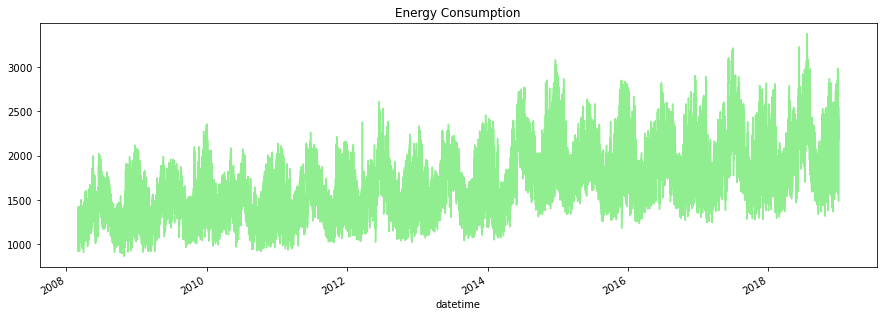

In [10]:
fig,ax=plt.subplots(figsize=(15,5))
train['energy'].plot(ax=ax,label='Traing data',title='Energy Consumption',color='lightgreen')

<AxesSubplot:xlabel='data_day_count'>

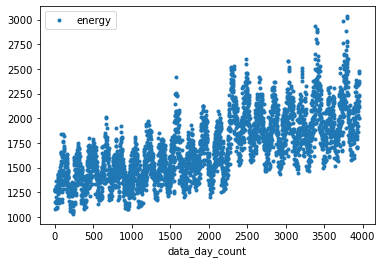

In [11]:
# Energy Distribution in hour interval
train[['energy','data_day_count']].groupby(by='data_day_count').mean().plot(style='.')

<AxesSubplot:xlabel='datetime'>

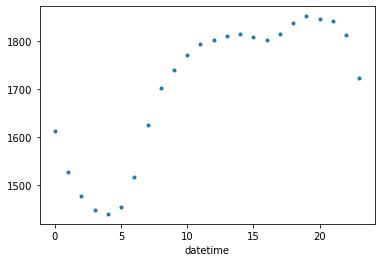

In [12]:
# Energy Distribution in hour interval
train['energy'].groupby(train.index.hour).mean().sort_values(ascending=False).plot(style='.')

<AxesSubplot:xlabel='datetime'>

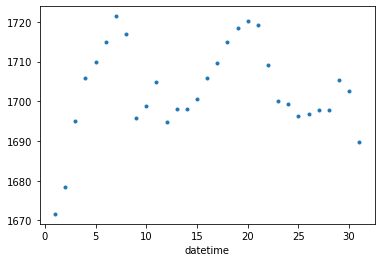

In [13]:
# Energy Distribution in day interval
train['energy'].groupby(train.index.day).mean().sort_values(ascending=False).plot(style='.')

<AxesSubplot:xlabel='datetime'>

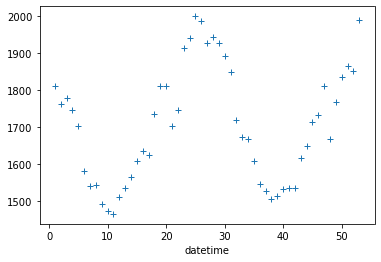

In [14]:
# Energy Distribution in week interval
train['energy'].groupby(train.index.week).mean().sort_values(ascending=False).plot(style='+')

<AxesSubplot:xlabel='datetime'>

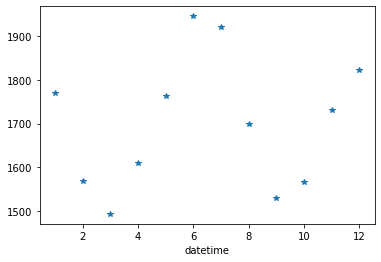

In [15]:
# Energy Distribution in Month interval
train['energy'].groupby(train.index.month).mean().sort_values(ascending=False).plot(style='*')

<AxesSubplot:xlabel='datetime'>

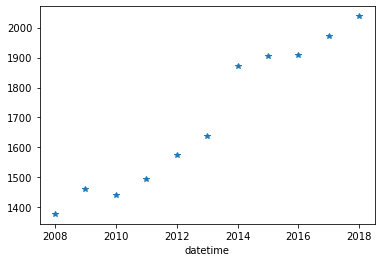

In [16]:
# Energy Distribution in year interval
train['energy'].groupby(train.index.year).mean().sort_values(ascending=False).plot(style='*')

<AxesSubplot:xlabel='datetime'>

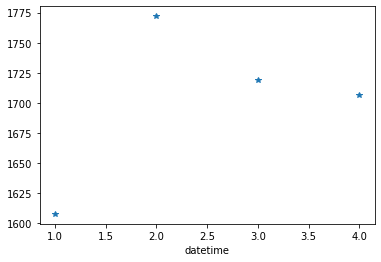

In [17]:
# Energy Distribution in Quater interval
train['energy'].groupby(train.index.quarter).mean().sort_values(ascending=False).plot(style='*')

# Feature Engineering

In [18]:
def date_time_features(ts_data,datetime='datetime'):
    '''
    Create Features from data frame using the df index 
    '''
    ts_data=ts_data.copy()
    ts_data['year']=ts_data.index.year    # Year 
    ts_data['month']=ts_data.index.month   # Month 
    ts_data['day']=ts_data.index.day   #Day
    ts_data['hour']=ts_data.index.hour   # hour
    ts_data['quater']=ts_data.index.quarter  #Quarter 
    ts_data['month_of_quater']=ts_data['month']%ts_data['quater']                      #month of each Quarter 
    ts_data['day_of_year']=ts_data.index.day_of_year                                   #Day of the year
    ts_data['day_of_quater']=ts_data['day_of_year']%ts_data['quater']                  #Day of each Quater
    ts_data['day_of_week']=ts_data.index.day_of_week                                   #Day of the Week
    ts_data['week_of_the_year']=ts_data.index.weekofyear                               #Week of the Year
    ts_data['is_weekend']=ts_data['day_of_week'].apply(lambda x : 1 if x==5 or x==6 else 0 ) #Is Weekend or not
    ts_data['is_morning']=ts_data['hour'].apply(lambda x : 1 if x>=6 and x<13 else 0)        #is morning(6am to 12pm)
    ts_data['morning_hour']=ts_data['hour'].apply(lambda x : x-5 if x>=6 and x<13 else 0)    #morning hour([1 to 7] or 0)
    ts_data['is_afternoon']=ts_data['hour'].apply(lambda x : 1 if x>=13 and x<18 else 0)     #is afternoon(1pm to 5pm)
    ts_data['afternoon_hour']=ts_data['hour'].apply(lambda x : x-12 if x>=13 and x<18 else 0)#afternoon hour([1 to 5] or 0)
    ts_data['is_evening']=ts_data['hour'].apply(lambda x : 1 if x>=18 and x<22 else 0)       #is_evening(6pm to 10pm)
    ts_data['evening_hour']=ts_data['hour'].apply(lambda x : x-17 if x>=18 and x<22 else 0)  #evening hour([1 to 5 ] or 0)
    ts_data['is_night']=ts_data['hour'].apply(lambda x : 1 if x>=22 or x<6 else 0)           #is_night(11pm to 5am)
    ts_data['night_hour']=ts_data['hour'].apply(lambda x: x-21 if x>21 else x+3)             #night hour([1 to 7] or 0)
    ts_data['is_am']=ts_data['hour'].apply(lambda x : 1 if x>=0 and x<13 else 0)             #is_am(dividing am seperaterly)
    ts_data['is_pm']=ts_data['hour'].apply(lambda x : 1 if x>=13 and x<24 else 0)            #is_pm(dividing pm seperaterly)
    ts_data['peak_hour']=ts_data['hour'].apply(lambda x : 1 if x in [19,20,21] else 0)       #peak hour(19,20,21 max energy consumption if yes:1 else:0)
    ts_data['off_hour']=ts_data['hour'].apply(lambda x : 1 if x in [3,4,5] else 0)           #off hour(3,4,5 min energy consumption if yes:1 else:0)
    ts_data['3hour_interval']=ts_data['hour']//3         #dividing 3hour interval (representing[0-3,4-6,7-9,10-12,13-15,16-18,19-21,22-24])
    ts_data['6hour_interval']=ts_data['hour']//6         #dividing 6hour interval (representing[0-6,7-12,13-18,19-24])
    
    return ts_data

In [19]:
# Feture Engineering
train=date_time_features(train)
test=date_time_features(test)

<AxesSubplot:>

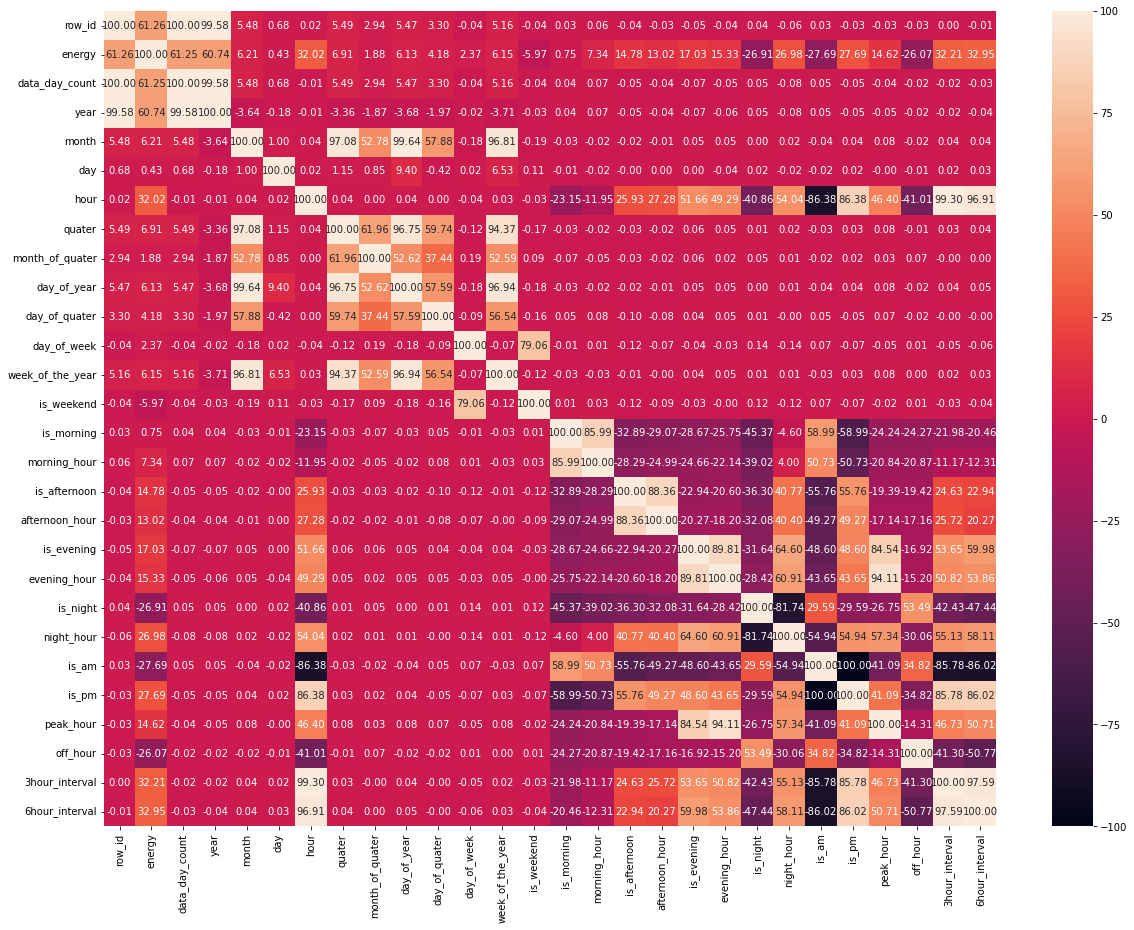

In [20]:
# Checking the Co-relation
plt.figure(figsize=(20,15))
sns.heatmap(train.corr()*100,annot=True,fmt='0.2f')

In [21]:
#Spliting Train and Validation set
train_set=train[(train.index<='28-02-2018')]
valid_set=train[(train.index>'28-02-2018')]

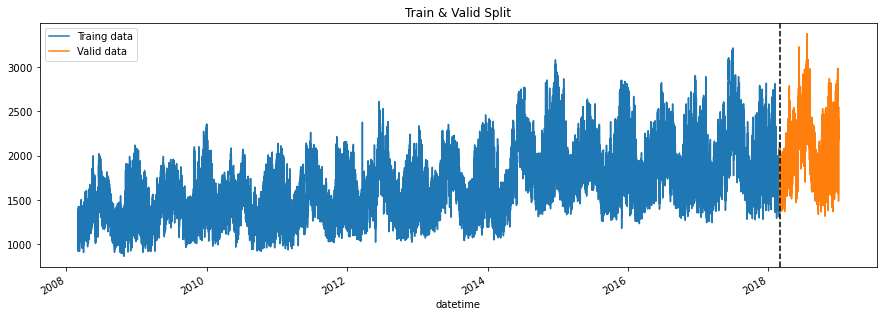

In [22]:
# Plot to Show the Training and Valadation set
fig,ax=plt.subplots(figsize=(15,5))
train_set['energy'].plot(ax=ax,label='Traing data',title='Train & Valid Split')
valid_set['energy'].plot(ax=ax,label='Valid data')
ax.axvline('28-02-2018',color='black',ls='--')
ax.legend()
plt.show()

In [23]:
# Spliting the Xtrain,Ytrain ,xtext an ytest
xtrain=train_set.drop(['energy'],axis=1)
ytrain=train_set.energy

xtest=valid_set.drop(['energy'],axis=1)
ytest=valid_set.energy

In [24]:
reg_model=xgb.XGBRegressor(n_estimators=1000,learning_rate=0.1,alpha=50,
                        early_stopping_rounds=50)
reg_model.fit(xtrain,ytrain,
             eval_set=[(xtrain,ytrain),(xtest,ytest)],verbose=10)

[0]	validation_0-rmse:1541.35346	validation_1-rmse:1894.27436
[10]	validation_0-rmse:560.46338	validation_1-rmse:756.74881
[20]	validation_0-rmse:238.43358	validation_1-rmse:373.33935
[30]	validation_0-rmse:146.04336	validation_1-rmse:260.82832
[40]	validation_0-rmse:123.33623	validation_1-rmse:228.08390
[50]	validation_0-rmse:115.50663	validation_1-rmse:217.17949
[60]	validation_0-rmse:110.56011	validation_1-rmse:213.59628
[70]	validation_0-rmse:106.62136	validation_1-rmse:212.12640
[80]	validation_0-rmse:103.03691	validation_1-rmse:208.28616
[90]	validation_0-rmse:100.12819	validation_1-rmse:208.05757
[100]	validation_0-rmse:97.57454	validation_1-rmse:207.92707
[110]	validation_0-rmse:94.74044	validation_1-rmse:208.81768
[120]	validation_0-rmse:91.93420	validation_1-rmse:208.63372
[130]	validation_0-rmse:88.93502	validation_1-rmse:209.32131
[140]	validation_0-rmse:87.12735	validation_1-rmse:206.36612
[150]	validation_0-rmse:85.12370	validation_1-rmse:205.54645
[160]	validation_0-rmse

XGBRegressor(alpha=50, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=50, ...)

In [25]:
# Prediction the Validation set
ypred=reg_model.predict(xtest)

In [26]:
#Checking R2 score for the model
r2_score(ytest,ypred)

0.6666600465107749

In [27]:
#Checking MSE score for the model
mean_squared_error(ytest,ypred)

41413.71977974956

In [28]:
#Checking RMSE score for the model
math.sqrt(mean_squared_error(ytest,ypred))

203.50361122041437

In [29]:
predicted_data=pd.DataFrame(ypred,index=ytest.index) 

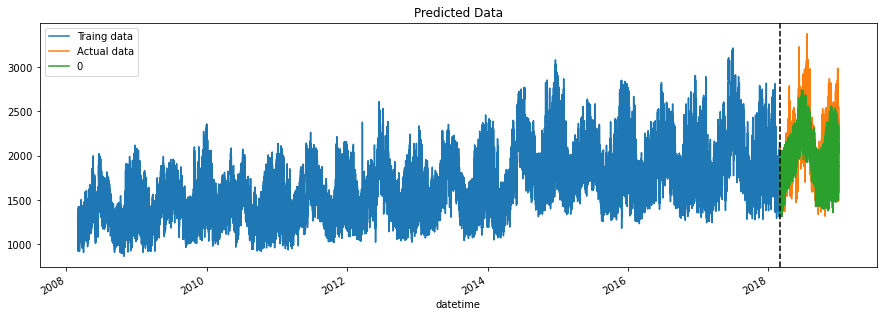

In [30]:
fig,ax=plt.subplots(figsize=(15,5))
ytrain.plot(ax=ax,label='Traing data',title='Predicted Data')
ytest.plot(ax=ax,label='Actual data')
predicted_data.plot(ax=ax,label='predicted data')
ax.axvline('28-02-2018',color='black',ls='--')
ax.legend()
plt.show()

In [31]:
#Actual data
xtrain=train.drop(['energy'],axis=1)
ytrain=train.energy

xtest=test
#ytest=valid_set.energy

In [32]:
#prediction the Value of the Test set
Actual_pred=reg_model.predict(xtest)
Actual_pred

array([1793.9117, 1696.231 , 1619.9897, ..., 2213.594 , 2139.175 ,
       2009.7806], dtype=float32)

In [33]:
# addinding the Predicted value to the Test set
xtest['energy']=Actual_pred

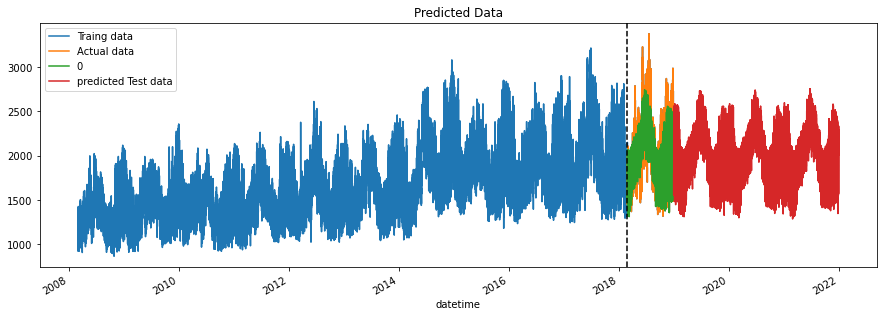

In [34]:
#Predicted Energy Consumpation with Test set
fig,ax=plt.subplots(figsize=(15,5))
ytrain.plot(ax=ax,label='Traing data',title='Predicted Data')
ytest.plot(ax=ax,label='Actual data')
predicted_data.plot(ax=ax,label='predicted Valid data')
xtest.energy.plot(ax=ax,label='predicted Test data')
ax.axvline('28-02-2018',color='black',ls='--')
ax.legend()
plt.show()

In [35]:
# Creating the Dataframe for Submission
base_model=xtest[['row_id','energy']]
base_model.to_csv('final_model_result1.csv',index=False)